In [2]:
import numpy as np  # Vectors and matrices
from scipy import stats  # Probability distributions
import matplotlib.pyplot as plt  # Plots
from matplotlib import style
import matplotlib as mpl
try:
    mpl.style.use('seaborn-v0_8')
except:
    mpl.style.use('seaborn')
mpl.rcParams['image.cmap'] = 'plasma'
nice_hist = dict(bins='auto', density=True, ec='w')

 #  Algorithme de Metropolis <a id="part2"></a>
 
 **On veut simuler (approximativement) une loi normale centrée réduite grâce à l'algorithme de Metropolis.**

 
 
 > **Question 1.**
 On choisit comme noyau de proposition $q$ de sorte que, pour tout $x \in \mathbb R$, $q(x, \cdot)$ corresponde à la densité de la variable aléatoire $Y=x+U$ avec $U \sim \mathcal U_{[-1/2,1/2]}$.
 Autrement dit, $q(x, \cdot)$ est la densité de probabilité d'aller en $y$ sachant qu'on part du point $x$. Déterminer $q(x,y)$. En déduire $q(y,x)$.

 >**Question 2.**
    Traduire l'algorithme de Metropolis-Hastings dans ce cadre.

Sachant qu'on part du point $x$, la variable aléatoire $Y$ suit une loi uniforme sur $[x-1/2,x+1/2]$, donc $q(x,y)=1$ si $|y-x|\leq 1/2$, et $q(x,y)=0$ sinon. On en déduit que $q(y,x)=1$ si $|y-x|\leq 1/2$, et $q(x,y)=0$ sinon. Autrement dit, le noyau de transition $q$ est symétrique : nous sommes dans le cadre d'application de l'algorithme de Metropolis, cas particulier de Metropolis-Hastings.

L'algorithme fonctionne donc comme suit : partant de $X_n=x$, on simule $W\sim{\cal U}_{[-1/2,1/2]}$ et on pose $Y=y=x+w$ ; en notant $\varphi$ la densité de la gaussienne centrée réduite, on calcule le rapport d'acceptation 
$$r(x,y)=\frac{\varphi(y)}{\varphi(x)}=e^{\frac{x^2-y^2}{2}},$$
on tire une loi uniforme $U\sim{\cal U}_{[0,1]}$, et on pose $X_{n+1}=Y=y$ si $U\leq r(x,y)$, sinon on reste sur place : $X_{n+1}=X_n=x$.


 >**Question 3.**
 Écrire une fonction `sample_metropolis(kernel, size=1, init=0.)` qui construit une chaîne de Markov de taille $n$ partant du point `init` selon l'algorithme décrit ci-avant.
 L'argument `kernel` représente la loi de $U$, ici : `kernel=stats.uniform(loc=-0.5, scale=1)`.
 La fonction devra retourner la réalisation de la chaîne et le taux d'acceptation.
 >

Appliquer cet algorithme pour construire une chaîne de longueur $n=10^4$ et partant d'un point $X_0$ tiré uniformément dans $[-3,3]$.

Le taux d'acceptation vaut : 0.9028


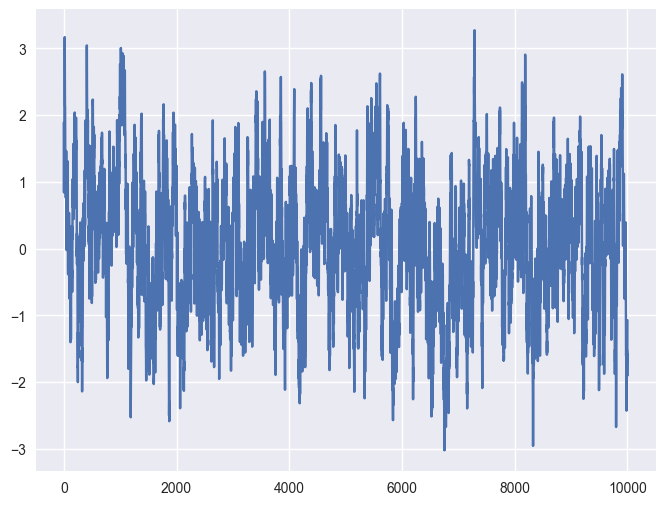

In [10]:
n = 10**4

def sample_metropolis(kernel, size=1, init=0.):
    unif = stats.uniform()
    threshold = unif.rvs(size=size)  
    move = kernel.rvs(size=size)
    
    sample = [init]
    n_acc = 0
    for i in range(size):
        X = sample[-1]
        Y = X + move[i]
        r = np.exp((X**2 - Y**2)/2)
        dec = threshold[i] < r 
        sample.append(Y if dec else X)
        n_acc += dec
    return np.asarray(sample), n_acc/size

sample, rate = sample_metropolis(stats.uniform(loc = -0.5, scale =1), n, init=stats.uniform.rvs(loc=-3, scale=6))
print("Le taux d'acceptation vaut :", rate)
plt.figure(figsize=(8,6))
plt.plot(list(range(len(sample))), sample)
plt.show()

Text(0.5, 1.0, "Taux d'acceptation : 0.9028")

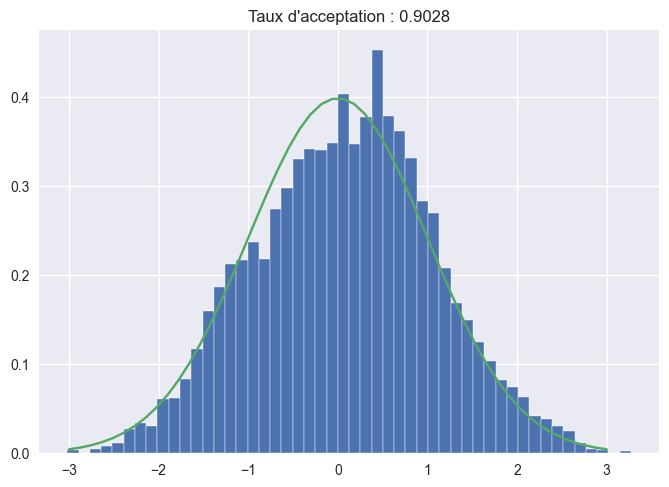

In [11]:
norm = stats.norm()

x = np.linspace(-3, 3)
plt.hist(sample, **nice_hist)
plt.plot(x, norm.pdf(x))
plt.title(f"Taux d'acceptation : {rate}")

Le taux d'acceptation vaut : 0.1598


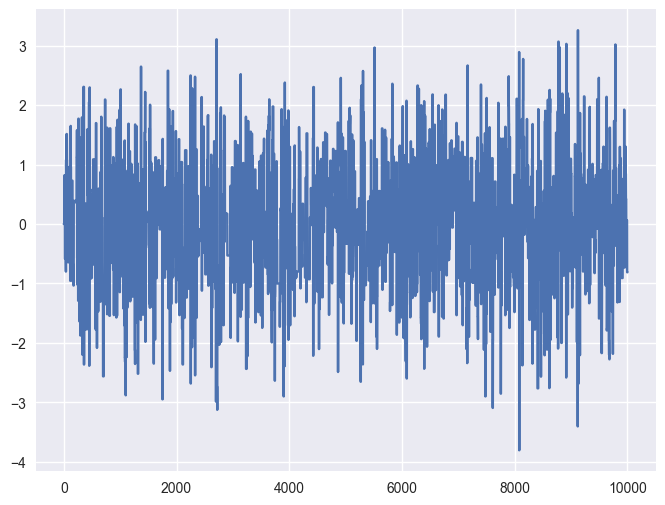

In [12]:
sample, rate = sample_metropolis(stats.uniform(loc = -10, scale =20), n, init=0)
print("Le taux d'acceptation vaut :", rate)
plt.figure(figsize=(8,6))
plt.plot(list(range(len(sample))), sample)
plt.show()

Text(0.5, 1.0, "Taux d'acceptation : 0.1598")

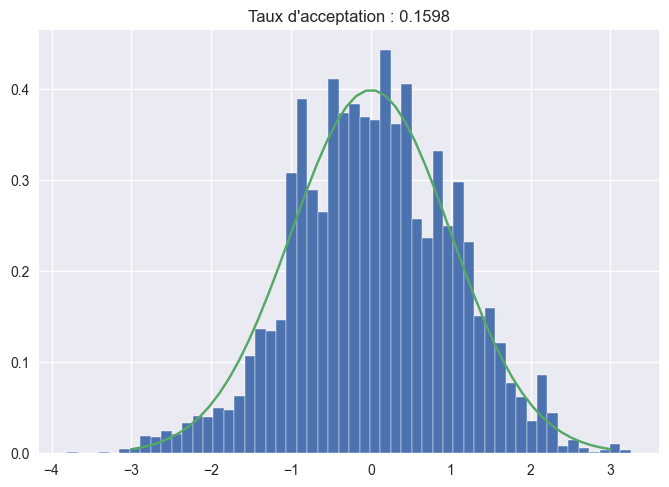

In [13]:
norm = stats.norm()

x = np.linspace(-3, 3)
plt.hist(sample, **nice_hist)
plt.plot(x, norm.pdf(x))
plt.title(f"Taux d'acceptation : {rate}")

Faible taux d'acceptation ...

# Algorithme de Gibbs 

>Soit $(X,Y)$ un couple aléatoire de densité jointe sur $\mathbb R^2$, $f : (x,y) \mapsto e^{-y}\mathbf{1}_{0\leq x\leq y}$.
 >
 >**Question 1.**
 Déterminer la loi marginale de $X$.

 En intégrant par rapport à $y$ la densité jointe, on voit que $X$ suit une loi exponentielle de paramètre 1.

 >**Question 2.**
 Sachant $X=x\geq0$, déterminer la densité conditionnelle de $Y | X=x$, notée $f_{Y | X=x}$. Quelle loi reconnaissez-vous ?

 Sachant $X=x\ge0$, on a 
 $$f_{Y | X=x}(y) \propto_y f(x, y) = e^{-y} \mathbf 1_{0 \le x \le y} \propto e^{-(y-x)} \mathbf 1_{y\ge x}.$$
 En d'autres termes, $Y \sim \mathcal E(1) + x$, loi exponentielle de paramètre $1$ translatée de $x$.

 >**Question 3.**
 En déduire une méthode pour simuler une réalisation du couple aléatoire $(X,Y)$. L'implémenter pour simuler un échantillon de couples $(X_1,Y_1),\dots,(X_n,Y_n)$ de taille $n=1000$. Représenter le nuage de points ainsi obtenu. 

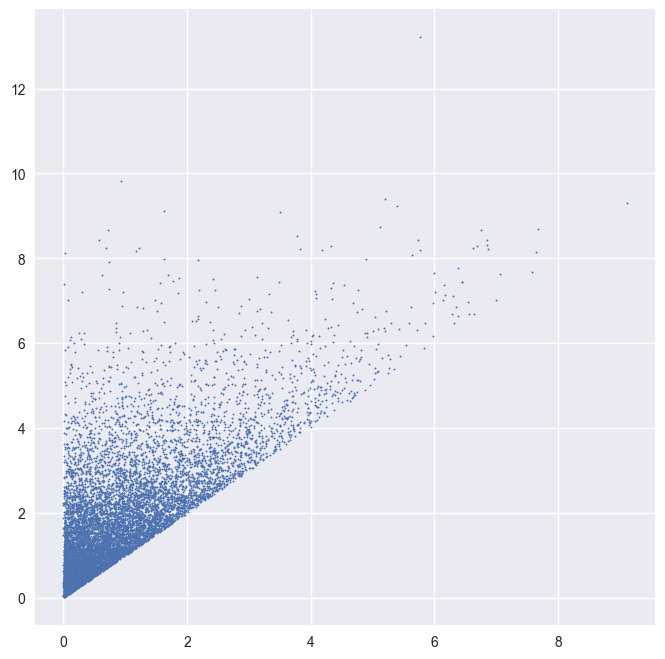

In [15]:
n = 10**4 
exp = stats.expon()
X = exp.rvs(size=n)
Y = np.asarray([exp.rvs() + x for x in X])
plt.figure(figsize=(8, 8))
plt.scatter(X, Y, s=1)

>**Question 4.**
Sachant $Y=y\geq 0$, déterminer la densité conditionnelle de $X | Y=y$, notée $f_{X | Y=y}$. Quelle loi reconnaissez-vous ?

 
 Sachant $Y=y\ge 0$, 
 $$f_{X | Y=y}(x) \propto_x f(x,y) \propto \mathbf 1_{0 \le x \le y},$$
 donc $X | Y=y \sim{\cal U}_{[0,y]}$.

 >**Question 5.**
 En partant par exemple du point $(x_0,y_0)=(0,1)$, proposer un échantillonneur de Gibbs pour obtenir une trajectoire $\left( (X_1, Y_1),\dots,(X_n, Y_n) \right)$ de densité cible $f$. Représenter le nuage de points ainsi obtenu.

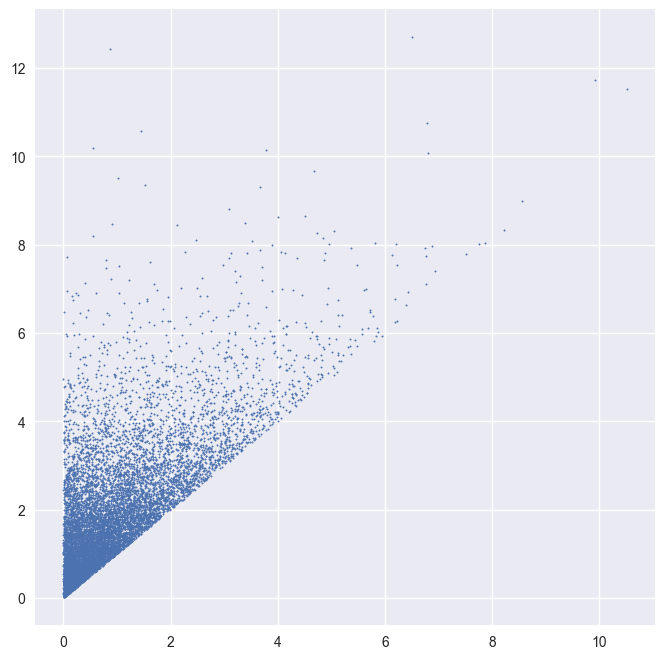

In [16]:
unif = stats.uniform()

X, Y = [0], [1]
for i in range(n-1):
    X.append(unif.rvs() * Y[-1])
    Y.append(X[-1] + exp.rvs())
    
plt.figure(figsize=(8, 8))
plt.scatter(X, Y, s=1)

La première méthode fournit directement un couple $(X,Y)$ distribué selon la densité jointe $f(x,y)$. Pour l'échantillonneur de Gibbs, à $n$ fixé, la densité du couple $(X_n,Y_n)$ n'est pas exactement $f(x,y)$ : cette propriété n'est qu'asymptotiquement vraie, lorsque $n\to\infty$. De plus, la première méthode fournit une suite indépendante, tandis qu'il y a une dépendance markovienne dans la suite de couples $(X_n,Y_n)$ simulée par l'échantillonneur de Gibbs. Bref il est clair qu'il faut choisir la première méthode, dite de simulation exacte.

## Metropolis vs rejet 

On considère la loi $G$ de densité sur $\mathbb{R}^2$ proportionnelle à 
$$ f(u,v) =   (\cos u ) ^2     ( \sin v) ^2  \operatorname{e}^{-0.05   (u^2 + v^2)}.$$

>**Question 1.**
Définir une fonction `F(U, V)` retournant $f(U, V)$ et utiliser le code ci-dessous pour afficher une représentation 3D de $f$ sur $[-5,5]\times[-5,5]$.

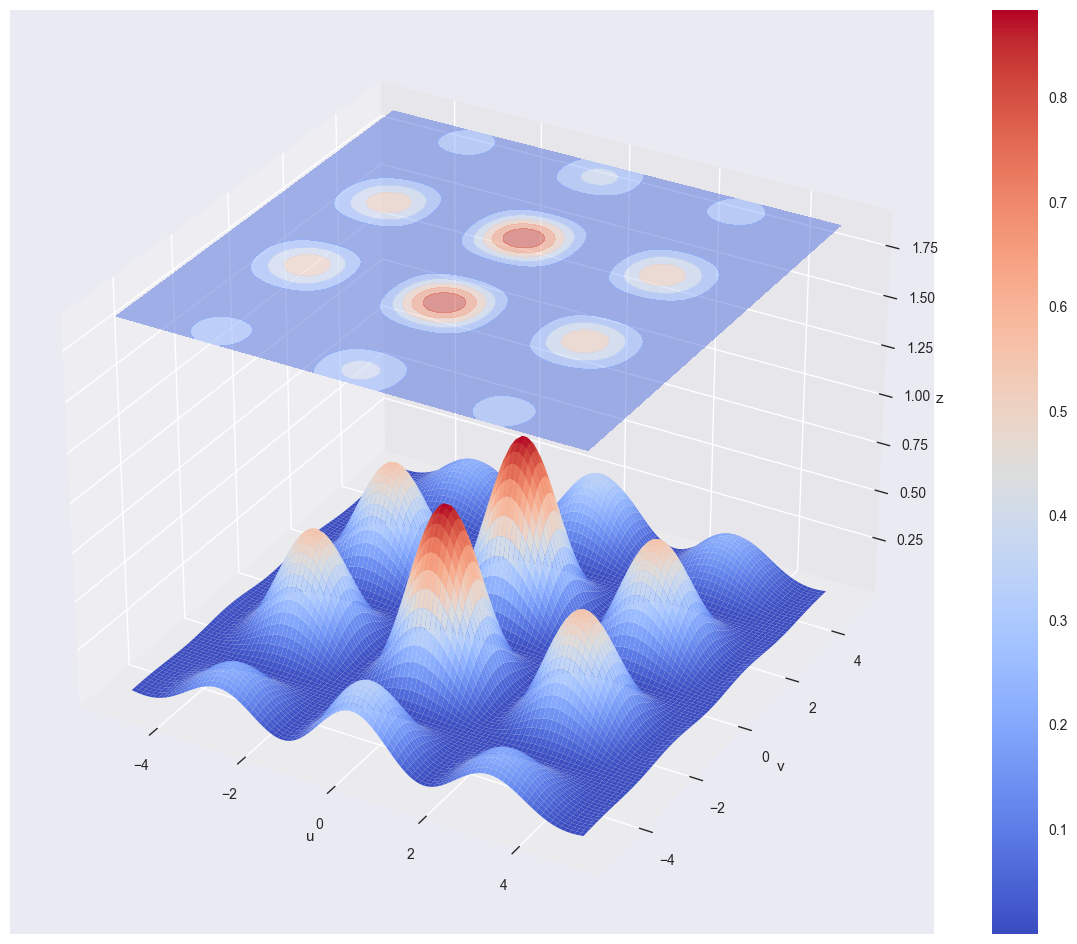

In [3]:
def plot_surf(U, V, Z, figsize=(15, 12)):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='3d'))
    # ax.view_init(30, 120)
    plt.rcParams['axes.grid'] = False
    surf = ax.plot_surface(U, V, Z, rstride=1, cstride=1, cmap="coolwarm", linewidth=0)
    ax.contourf(U, V, Z, zdir='z', offset=Z.max()+1, cmap="coolwarm", alpha=0.5)
    ax.set_zlim(top=Z.max()+1)
    fig.colorbar(surf)
    ax.set_xlabel('u')
    ax.set_ylabel('v')
    ax.set_zlabel('z')
    plt.rcParams['axes.grid'] = True
    return fig, ax

def F(U, V):
    return np.cos(U)**2 * np.sin(V)**2 * np.exp(-0.05 * (U**2 + V**2))

u = np.linspace(-5, 5, num=100)
v = np.linspace(-5, 5, num=100)
U, V = np.meshgrid(u, v)  # All possible pairs from u and v

# Compléter
Z = F(U, V)
# Fin compléter
plot_surf(U, V, Z)

On constate que f a beaucoup de maxima locaux.

>**Question 2.**
On veut simuler (approximativement) selon la loi $G$ en utilisant l'algorithme de Metropolis-Hastings.
>Partant de $x=(u,v)$, on considère le noyau de proposition $q$ défini de sorte que $q(x,\cdot)$ corresponde à la densité de $Y=x+\sigma W$, où $\sigma>0$ est un paramètre de réglage et $W\sim{\cal N} \left(\binom 00,I_2 \right)$, loi gaussienne centrée réduite dans $\mathbb{R}^2$.
>Expliquer pourquoi nous sommes dans le cadre de l'algorithme de Metropolis.

Puisque $X'=x+\sigma W$, $q(x,x')$ est, vue comme une fonction de $x'$, la densité d'une gaussienne centrée en $x$ et de matrice de covariance $\sigma^2 I_2$, c'est-à-dire en notant $\|\cdot\|$ la norme euclidienne :
$$q(x,x')=\frac{1}{2\pi\sigma^2}\exp\left\{-\frac{1}{2\sigma^2}\|x'-x\|^2\right\}.$$

Cette formule étant symétrique en $x$ et $x'$, il est clair que $q(x,x')=q(x',x)$, donc on est dans le cadre de l'algorithme de Metropolis.

>**Question 3.**
Implémenter l'algorithme de Metropolis. On utilisera le noyau de transition $q$ ci-dessus avec $\sigma=1$. On pourra par exemple prendre comme initialisation $X_1=(0,0)$ et considérer une chaîne $(X_k)_{0\leq k\leq n}$ de longueur $n=10^4$. En fin de simulation, afficher le taux global d'acceptation sur l'ensemble des mutations proposées.

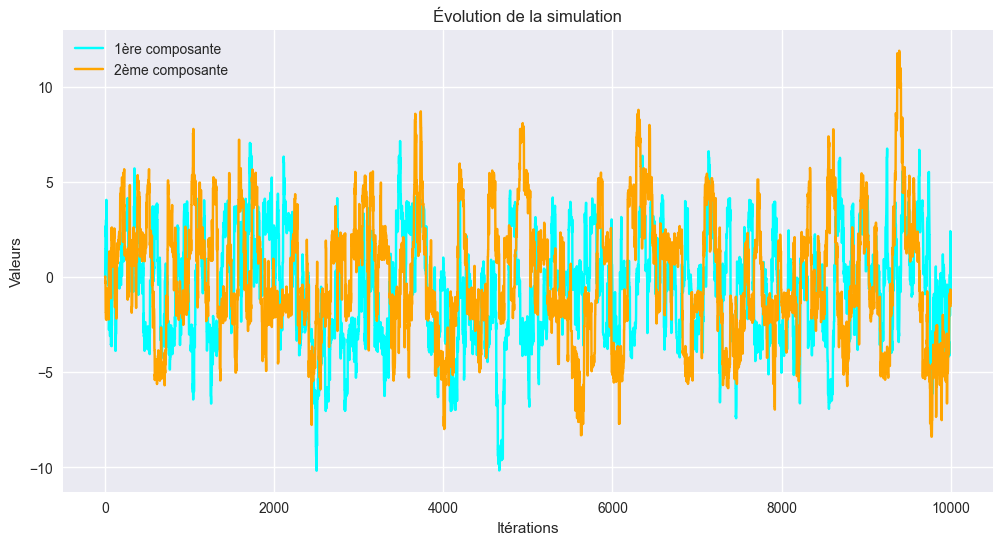

Taux d'acceptation : 0.4312


In [25]:
n, sigma = 10**4, 1

def f(x):
    u,v = x 
    return F(u,v)

def sample_metropolis_2d(kernel, size=1, init=(0., 0.)):
    threshold, move = np.random.uniform(size = size-1), kernel.rvs(size = size-1)
    sample = [init]
    n_acc = 0 
    for i in range(size-1):
        x = sample[-1]
        y = x + move[i]
        crit = 1 if f(x)==0 else f(y) / f(x)
        dec = threshold[i] < crit
        sample.append(y if dec else x)
        n_acc += dec
    return np.asarray(sample), n_acc/size

sample, rate = sample_metropolis_2d(stats.multivariate_normal(mean = np.zeros(2),cov= sigma**2 * np.eye(2)), n)
plt.figure(figsize=(12,6))
plt.title("Évolution de la simulation")
plt.plot(list(range(len(sample))), sample[:,0], label = "1ère composante", color = "cyan")
plt.plot(list(range(len(sample))), sample[:,1], label = "2ème composante", color = "orange")
plt.xlabel("Itérations")
plt.ylabel("Valeurs")
plt.legend()
plt.show()
print(f"Taux d'acceptation : {rate}")


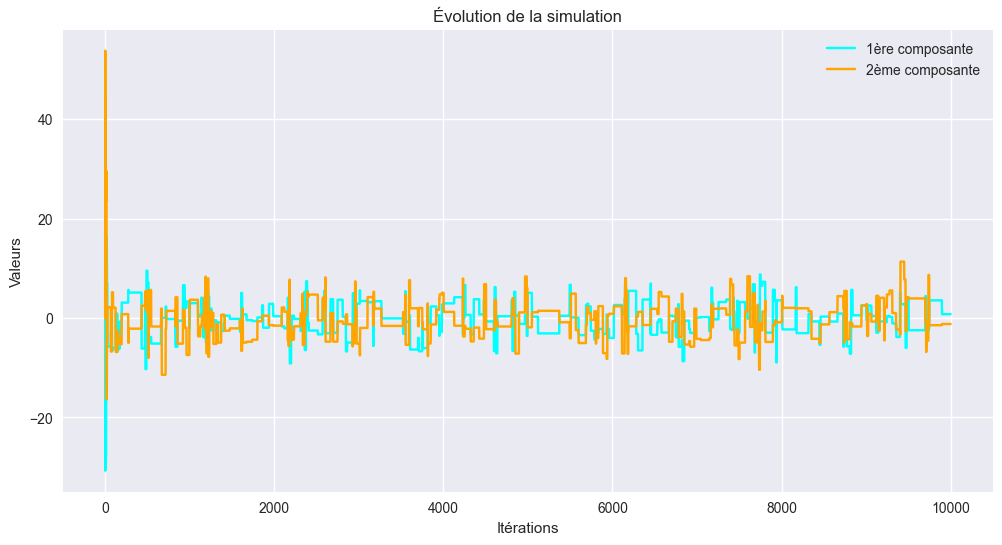

Taux d'acceptation : 0.0288


In [27]:
n, sigma = 10**4, 20
sample, rate = sample_metropolis_2d(stats.multivariate_normal(mean = np.zeros(2),cov= sigma**2 * np.eye(2)), n)
plt.figure(figsize=(12,6))
plt.title("Évolution de la simulation")
plt.plot(list(range(len(sample))), sample[:,0], label = "1ère composante", color = "cyan")
plt.plot(list(range(len(sample))), sample[:,1], label = "2ème composante", color = "orange")
plt.xlabel("Itérations")
plt.ylabel("Valeurs")
plt.legend()
plt.show()
print(f"Taux d'acceptation : {rate}")

>**Question 4.**
Sur le graphe de $f$ par lignes de niveau (`plt.contourf(U, V, Z, cmap=cm.coolwarm, alpha=0.5)`), superposer les points de la chaîne. Faire la même chose avec $\sigma$ grand, par exemple $\sigma=10$, et commenter. Idem avec $\sigma$ petit, par exemple $\sigma=0.1$. Afficher les taux d'acceptation dans les deux cas.

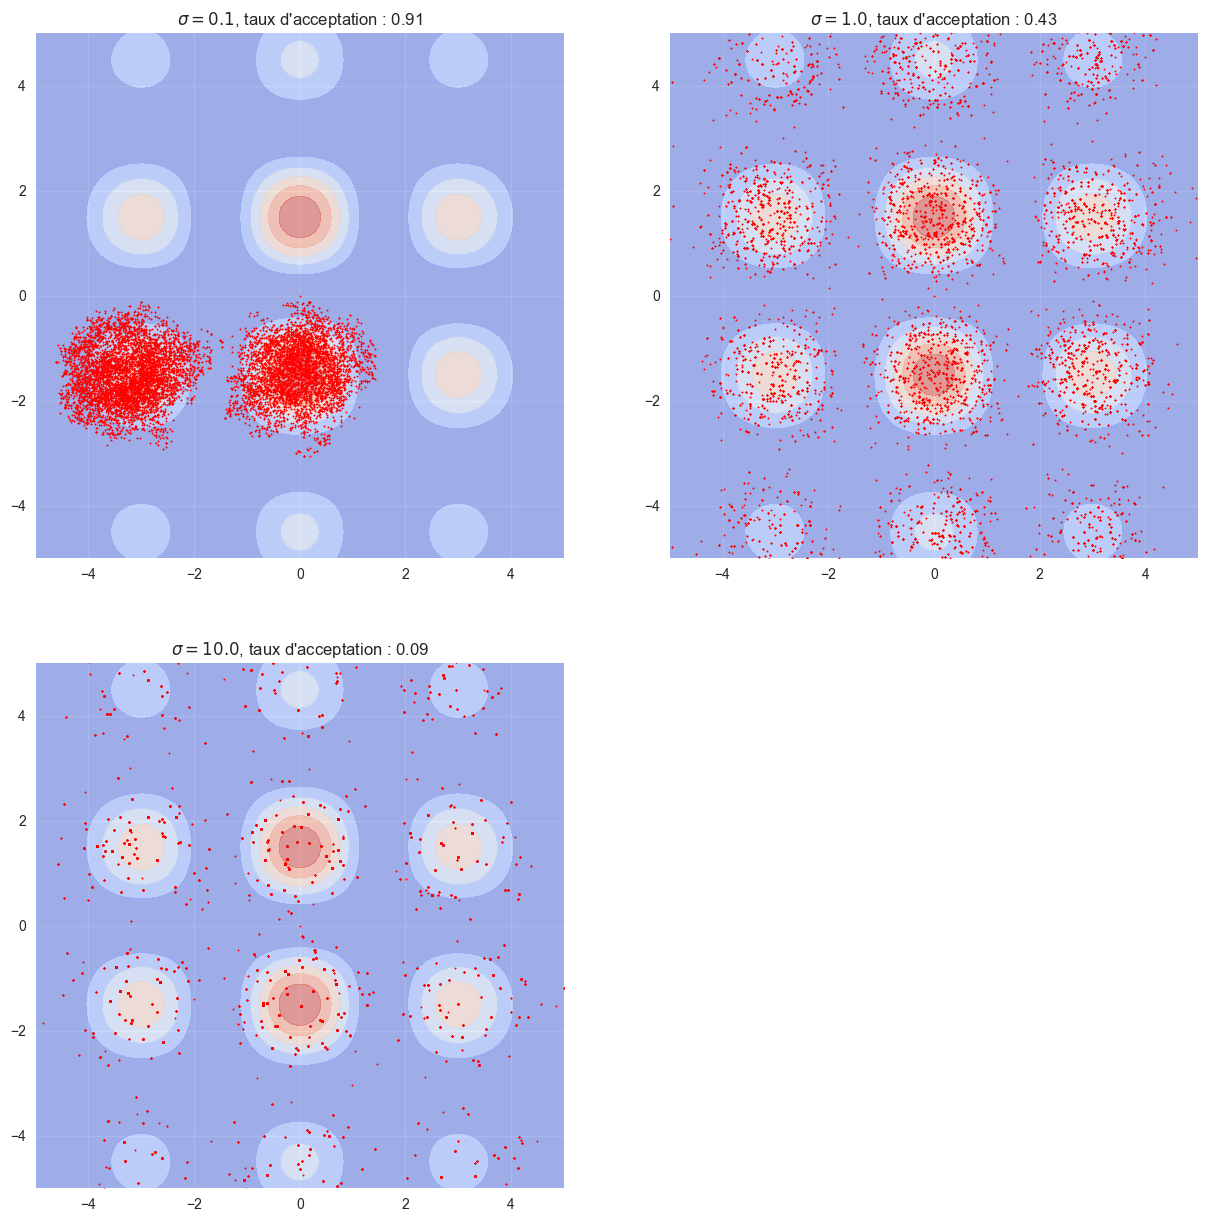

In [28]:
plt.figure(figsize=(15, 15))
for i, sigma in enumerate([0.1, 1, 10]):
    sample, rate = sample_metropolis_2d(stats.multivariate_normal(cov=sigma**2 * np.eye(2)), n)
    plt.subplot(2, 2, i+1)
    plt.contourf(U, V, Z, cmap="coolwarm", alpha=0.5)
    plt.scatter(*sample.T, c='r', s=1)
    plt.xlim([U.min(), U.max()])
    plt.ylim([V.min(), V.max()])
    plt.title(f"$\\sigma={sigma:.1f}$, taux d'acceptation : {rate:.2f}")

- Lorsque $\sigma=1$, la chaîne parvient à visiter plusieurs maxima locaux et on obtient donc une approximation satisfaisante de la loi cible $G$.
 - Lorsque $\sigma$ est grand, par exemple $\sigma=10$, il y a beaucoup de propositions là où la densité de $G$ est faible, lesquelles ont donc toutes les chances d'être refusées. La loi $G$ est donc nettement moins bien échantillonnée. C'est ce qu'on constate sur le graphique.
 Le taux d'acceptation est, comme on s'y attend, désastreux.
 - A contrario, lorsque $\sigma$ est petit, par exemple $\sigma=0.1$, chaque proposition est très proche du point précédent donc a de grandes chances d'être acceptée. Cependant la chaîne bouge très lentement donc là encore la loi $G$ est mal échantillonnée. C'est ce qu'on constate sur le graphique.
 Le taux d'acceptation est en effet très élevé.

>**Question 5.**
Proposer une méthode de rejet pour simuler suivant la loi $G$ à partir d'une loi instrumentale gaussienne. Comme en question précédente, superposer un échantillon de grande taille simulé par cette méthode aux niveaux de la fonction $f$ pour vérifier visuellement le bon fonctionnement de l'algorithme.

 On commence par noter que
$$\forall(u,v)\in\mathbb{R}^2\hspace{1cm}f(u,v)\leq\exp\left(-0.05(u^2+v^2)\right)=\exp\left(-\frac{1}{20}(u^2+v^2)\right).$$
 Soient donc
 $$h(u,v)=\frac{1}{20\pi}\exp\left(-\frac{1}{20}(u^2+v^2)\right)$$
 la densité d'une loi normale centrée et de matrice de covariance $10 I_2$
 et $g = c \cdot f$ la densité de $G$ (avec $c>0$ la constante de normalisation).
 On a ainsi
 $$\forall(u,v)\in\mathbb{R}^2\hspace{1cm}g(u,v) = c f(u, v) \leq 20\pi\times c\times h(u,v),$$
 ou encore 
 $$\forall(u,v)\in\mathbb{R}^2\hspace{1cm}\frac{g(u,v)}{h(u,v)}=20\pi c(\cos u)^2(\sin v)^2\leq 20\pi c.$$
 En prenant $m=20\pi c$, le rapport d'acceptation vaut donc tout simplement
 $$r(u,v)=(\cos u)^2(\sin v)^2.$$
 
 La simulation de la loi $G$ par méthode de rejet avec $h$ comme loi instrumentale s'en déduit simplement.

Text(0.5, 1.0, "Taux d'acceptation : 0.26")

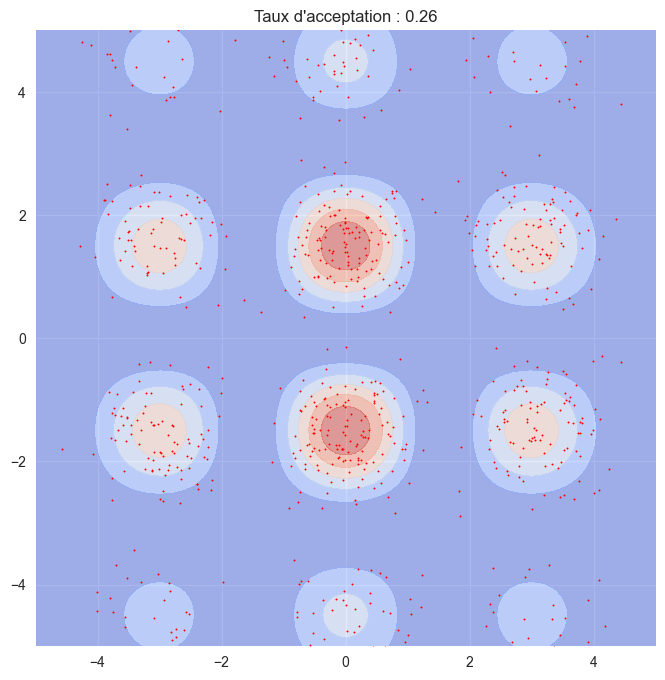

In [29]:
aux = stats.multivariate_normal(cov=10*np.eye(2))
unif = stats.uniform()

n = 10**3

sample = []
n_tot = 0
for i in range(n):
    candidate = aux.rvs()
    n_tot += 1
    # Compléter
    while np.cos(candidate[0])**2 * np.sin(candidate[1])**2 < unif.rvs():
        candidate = aux.rvs()
        n_tot += 1
    # Fin compléter
    sample.append(candidate)
sample = np.asarray(sample)
rate = n / n_tot

plt.figure(figsize=(8, 8))
plt.contourf(U, V, Z, cmap="coolwarm", alpha=0.5)
plt.scatter(*sample.T, c='r', s=1)
plt.xlim([U.min(), U.max()])
plt.ylim([V.min(), V.max()])
plt.title(f"Taux d'acceptation : {rate:.2f}")

Pour l'algorithme de rejet, on sait que le taux d'acceptation moyen est égal $\frac{1}{20\pi c}$, mais $c$ est inconnu.
Une estimation par comptage donne $\frac{1}{20\pi c} \approx \frac 14$.
 
 Avec l'algorithme de rejet, il faut donc simuler environ $4n$ couples $(U,V)$ pour obtenir un échantillon de taille $n$. A contrario, pour $n$ simulations, l'algorithme de Metropolis fournit exactement un échantillon de taille $n$, incluant des répétitions. On peut cependant noter que l'algorithme de rejet fournit un échantillon i.i.d. selon la loi cible $G$, tandis que l'algorithme de Metropolis construit seulement une chaîne de Markov de loi stationnaire $G$ : on n'a ni indépendance, ni une simulation selon $G$ exactement (ce n'est vrai qu'asymptotiquement).  

## Exercice 5 : Algorithme de Metropolis pour l'échantillonnage d'une loi a posteriori <a id="part5"></a>

>On considère le modèle bayésien :

 \begin{cases}
     \boldsymbol \theta \sim {\cal U}_{[0,1]} \\
     (X_1, \dots, X_n) | \boldsymbol \theta \sim \left( \boldsymbol \theta \mathcal N(1, 1) + (1-\boldsymbol \theta) \mathcal N(-1, 1) \right)^{\otimes n}.
     %\mathbf X | \boldsymbol \theta \sim \left( \boldsymbol \theta N(1, 1) + (1-\boldsymbol \theta) N(-1, 1) \right)^{\otimes n}.
 \end{cases}

 Notons $\phi$ la densité de $\mathcal N(0, 1)$. Ainsi, sachant $\boldsymbol \theta = \theta$,  $X_1$ a pour densité $\theta \phi(x-1) + (1-\theta) \phi(x+1)$.
 On remarque aussi que, sachant $\boldsymbol \theta = \theta$, $X_1\overset{\mathcal{L}}{=} Z Y_1 + (1-Z) Y_{-1}$, où $Y_1, Y_{-1}$ et $Z$ sont trois variables aléatoires indépendantes de lois respectives $\mathcal N(1, 1)$, $\mathcal N(-1, 1)$ et $\mathcal B(\theta)$.
 >

 >**Question 1.**
 Soit $\theta_0$ une réalisation de $\boldsymbol \theta$.
 Pour $n=100$, générer une réalisation de $X_1,\dots,X_n$ selon le mélange ci-dessus pondéré par $\theta_0$.

theta0 = 0.37222232879120265


(array([0.05851766, 0.13166473, 0.24870004, 0.29258828, 0.32184711,
        0.13166473, 0.11703531, 0.1024059 , 0.05851766]),
 array([-3.12377597, -2.44022159, -1.75666721, -1.07311283, -0.38955845,
         0.29399593,  0.97755031,  1.66110469,  2.34465907,  3.02821345]),
 <BarContainer object of 9 artists>)

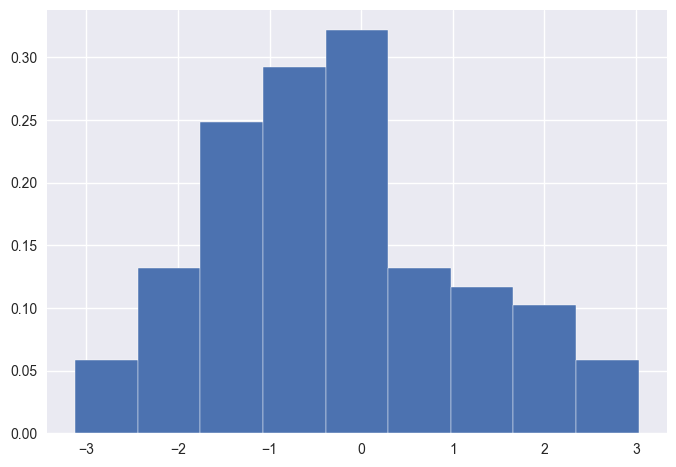

In [37]:
prior = stats.uniform()
theta0 = prior.rvs()

ber = stats.bernoulli(theta0)
normp = stats.norm(loc=1)
normm = stats.norm(loc=-1)

n = 100
choice = ber.rvs(size=n)
X = choice * normp.rvs(size=n) + (1-choice) * normm.rvs(size=n)

print(f'theta0 = {theta0}')
plt.hist(X, **nice_hist)

>**Question 2.**
Expliciter la loi a posteriori $\Pi[\cdot | \mathbf X]$ et l'estimateur de Bayes $\hat \theta_n$ pour la perte quadratique.


La densité a posteriori s'obtient par la formule de Bayes :
 $$\pi(\theta|{\bf X})=\frac{\pi(\theta) p_\theta (\bf X)}{f({\bf X})}=C_{\bf X}\prod_{i=1}^n\left\{\theta\phi(X_i-1)+(1-\theta)\phi(X_i+1)\right\}\mathbf{1}_{[0,1]}(\theta),$$
 où, comme d'habitude, la constante de normalisation
 $$C_{\bf X}=\left(\displaystyle\int_0^1\prod_{i=1}^n\left\{t\phi(X_i-1)+(1-t)\phi(X_i+1)\right\}dt\right)^{-1}$$
 dépend de ${\bf X}$ mais pas de $\theta$. L'estimateur de Bayes pour la perte quadratique $\hat\theta_n$ est par définition l'espérance de $\boldsymbol \theta | \mathbf X$, c'est-à-dire
 $$\hat\theta_n=\displaystyle\int_\mathbb{R}\theta\ \pi(\theta|{\bf X}) d\theta=C_{{\bf X}}\displaystyle\int_0^1\theta\prod_{i=1}^n\left\{\theta\phi(X_i-1)+(1-\theta)\phi(X_i+1)\right\}d\theta.$$
 On ne dispose pas de formule analytique évidente pour calculer cette intégrale, d'où le recours aux méthodes Monte-Carlo dans la suite.

 >**Question 3.**
En déduire un estimateur Monte-Carlo $\hat\theta_n^N$ de la réalisation de l'estimateur de Bayes $\hat\theta_n$. L'implémenter pour $N=500$ par exemple. 

 Un estimateur Monte-Carlo $\hat\theta_n^N$ de la réalisation de l'estimateur de Bayes $\hat\theta_n$ est 
 $$\hat\theta_n^N=\frac{\tfrac{1}{N}\sum_{j=1}^N \theta_j p_{\theta_j}(\mathbf X)}{\tfrac{1}{N}\sum_{j=1}^N p_{\theta_j}(\mathbf X)}=\frac{\displaystyle\sum_{j=1}^N \theta_j\prod_{i=1}^n\left\{\theta_j\phi(X_i-1)+(1-\theta_j)\phi(X_i+1)\right\}}{\displaystyle\sum_{j=1}^N \prod_{i=1}^n\left\{\theta_j\phi(X_i-1)+(1-\theta_j)\phi(X_i+1)\right\}}.$$

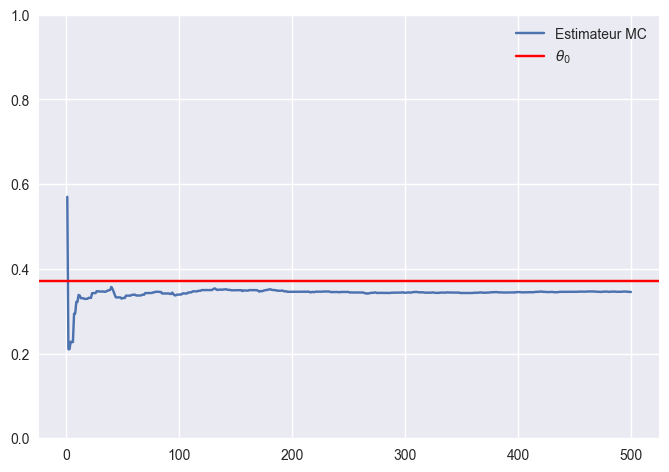

In [39]:
N = 500

thetas = prior.rvs(size=N)
likelihood = np.asarray([(theta * normp.pdf(X) + (1-theta) * normm.pdf(X)).prod() for theta in thetas])
estMC = (thetas * likelihood).cumsum() / likelihood.cumsum()
# Fin compléter

plt.plot(np.arange(1, N+1), estMC, label = "Estimateur MC")
plt.axhline(theta0, color="red", label="$\\theta_0$")
plt.ylim(0, 1)
plt.legend()

>**Question 4.**
>On souhaite générer un échantillon suivant la loi a posteriori $\Pi[\cdot | \mathbf X]$. On adopte pour cela la méthode de Metropolis-Hastings (qui fournira donc approximativement un échantillon de loi $\Pi[\cdot | \mathbf X]$, i.e. une trajectoire de loi cible $\Pi[\cdot | \mathbf X]$) avec comme noyau de proposition $q$, de sorte que $q(\theta,\theta')=\mathbf 1_{[0,1]}(\theta')$.
 Quelle est la loi de proposition ?
 Que vaut le rapport de Metropolis-Hastings $r(\theta,\theta')$ ?
 >Avec la condition initiale $\boldsymbol \theta_1=1/2$, implémenter l'algorithme pour une chaîne de longueur $m=10^4$ et représenter un estimateur de la densité de la trajectoire $(\boldsymbol \theta_1,\dots,\boldsymbol \theta_m)$. Donner le taux global d'acceptation sur l'ensemble des mutations proposées.

 Clairement, la loi de proposition correspondante à $q$, dont la densité est, pour tout $\theta \in \mathbb R$, $q(\theta, \cdot)$, est la loi $\mathcal U([0, 1])$.
 Elle est indépendante de $\theta$ (en particulier, ce n'est pas une loi translatée comme dans les cas précédents),
 mais ce n'est qu'une proposition : le prochain point de la chaîne de Markov dépendra, lui, bien du point courant (cf le rapport de Metropolis-Hastings).
 
 Par ailleurs, le rapport de Metropolis-Hastings vaut, pour tous $\theta \in \mathbb R$ et $\theta \in \mathbb R$ :
  
  \begin{align*}
 
   r(\theta,\theta')
   &= \frac{\pi(\theta' | {\mathbf X})}{\pi(\theta | {\mathbf X})} \frac{q(\theta', \theta)}{q(\theta, \theta')}   
    = \frac{\pi(\theta') p_{\theta'}(\mathbf X)}{\pi(\theta) p_{\theta}(\mathbf X)} \frac{q(\theta', \theta)}{q(\theta, \theta')}
   = \frac{\mathbf 1_{[0, 1]}(\theta') p_{\theta'}(\mathbf X)}{\mathbf 1_{[0, 1]}(\theta) p_{\theta}(\mathbf X)} \frac{\mathbf 1_{[0, 1]}(\theta)}{\mathbf 1_{[0, 1]}(\theta')} \\
   &= \frac{p_{\theta'}(\mathbf X)}{p_{\theta}(\mathbf X)}
   = \frac{\prod_{i=1}^n\left\{\theta'\phi(X_i-1)+(1-\theta')\phi(X_i+1)\right\}}{\prod_{i=1}^n\left\{\theta\phi(X_i-1)+(1-\theta)\phi(X_i+1)\right\}}

 \end{align*}

Taux d'acceptation : 0.20


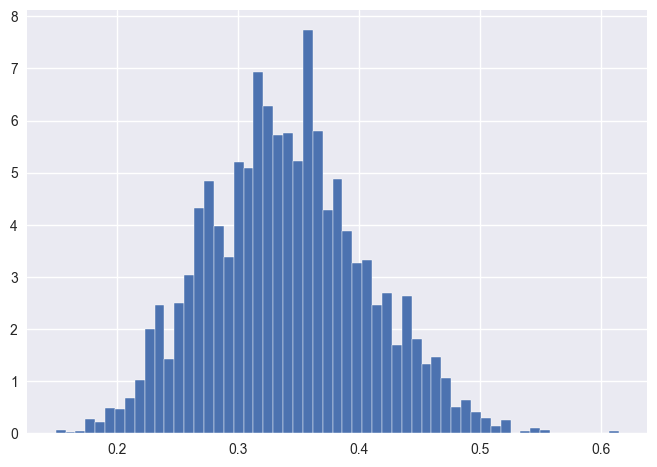

In [40]:
m = 10**4
init = 0.5

threshold = prior.rvs(size=m-1)
move = prior.rvs(size=m-1)

sample = [init]
for i in range(m-1):
    x = sample[-1]
    y = move[i]
    crit = np.prod(y * normp.pdf(X) + (1-y) * normm.pdf(X)) / np.prod(x * normp.pdf(X) + (1-x) * normm.pdf(X))
    dec = threshold[i] < crit
    sample.append(y if dec else x)


plt.hist(sample, **nice_hist)
print(f"Taux d'acceptation : {len(np.unique(sample)) / m:.2f}")

>**Question 5.**
Mêmes questions en considérant le noyau de transition correspondant à $\boldsymbol \theta' = \boldsymbol \theta+U/\sqrt{n}$ (modulo 1), avec $U \sim \mathcal U_{[-1,1]}$.

Taux d'acceptation : 0.70


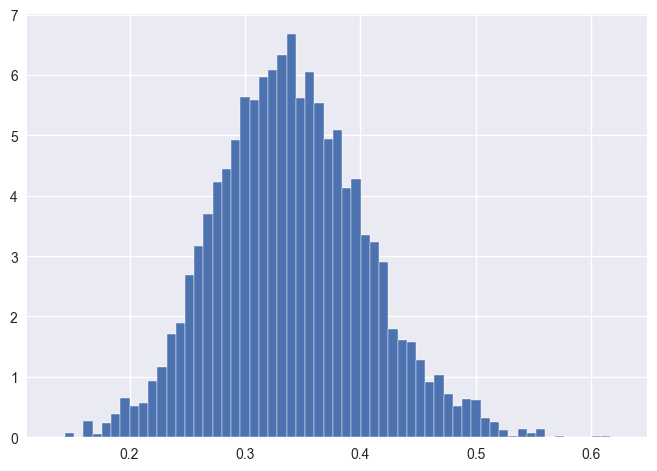

In [41]:
m = 10**4
init = 0.5

unif = stats.uniform()
kernel = stats.uniform(loc=-1, scale=2)

threshold = unif.rvs(size=m-1)
move = kernel.rvs(size=m-1) / np.sqrt(n)

sample = [init]
for i in range(m-1):
    x = sample[-1]
    y = (x + move[i]) % 1
    crit = np.prod(y * normp.pdf(X) + (1-y) * normm.pdf(X)) / np.prod(x * normp.pdf(X) + (1-x) * normm.pdf(X))
    dec = threshold[i] < crit
    sample.append(y if dec else x)

plt.hist(sample, **nice_hist)
print(f"Taux d'acceptation : {len(np.unique(sample)) / m:.2f}")